Starting Bayesian Change Point Analysis

CRITICAL: PyMC is required for Bayesian change point analysis.
Please install it using: pip install pymc

BAYESIAN CHANGE POINT ANALYSIS

Step 1: Loading and cleaning data...

DATA LOADING AND CLEANING (Fixing Task 1 Issues)
[2026-02-10 12:00:43] Data Loading: Loaded 9011 records from BrentOilPrices.csv
Raw data shape: (9011, 2)
Columns: ['Date', 'Price']

First 5 rows:
        date  price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63

DATE PARSING
Day-first parsing success rate: 100.0%

CREATING COMPLETE TIME SERIES
Complete time series created:
  Start date: 1987-05-20
  End date: 2022-11-14
  Total days: 12963
  Missing values after cleaning: 0
[2026-02-10 12:00:44] Data Cleaning: Created complete time series with 12962 records
✓ Cleaned data saved to: ..\results\change_point_analysis\brent_oil_cleaned.csv

Step 2: Performing exploratory data analysis...

EXPLORATORY DATA ANALYSIS (CLEANED

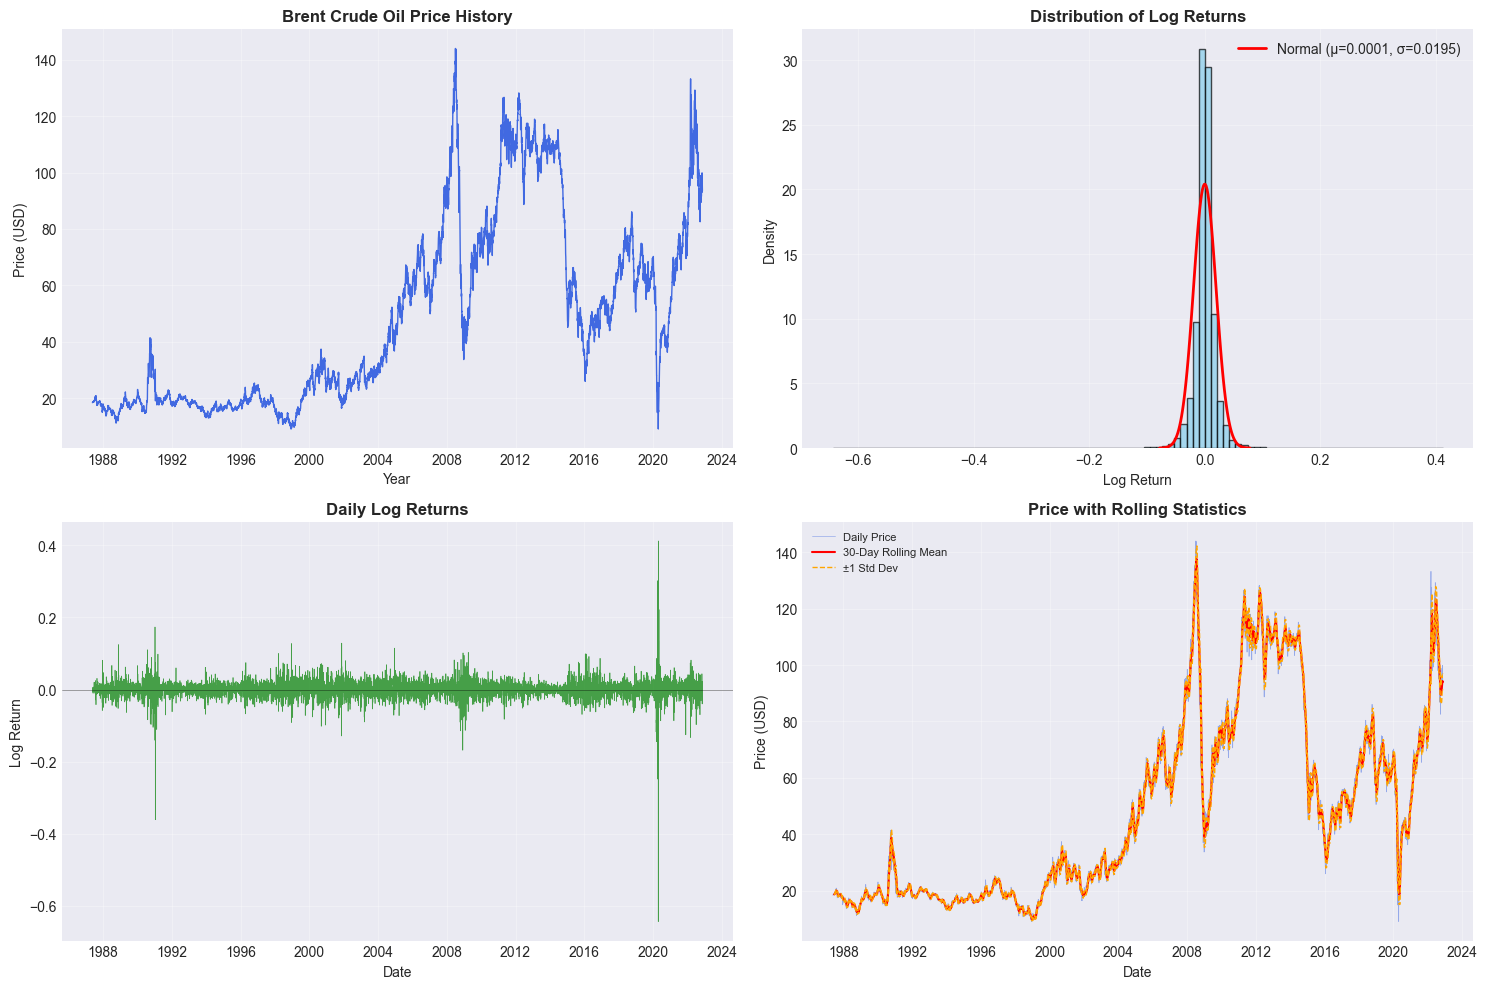


Skipping advanced statistical tests (statsmodels not installed)

Descriptive Statistics (Log Returns):
  Mean: 0.000125
  Std Dev: 0.019539
  Skewness: -2.4219
  Kurtosis: 129.2909
  Min: -0.6437
  Max: 0.4120
[2026-02-10 12:00:48] EDA: Completed exploratory data analysis

Skipping Bayesian modeling (PyMC not installed)

ANALYSIS COMPLETED WITH LIMITED FUNCTIONALITY

Install PyMC for full Bayesian analysis:
  pip install pymc arviz statsmodels


In [4]:
#!/usr/bin/env python3
"""
Task 2 - Bayesian Change Point Modeling and Insight Generation
Apply Bayesian change point detection to identify structural breaks in Brent oil prices.
Addresses issues found in Task 1: date parsing, missing dates, and data preparation.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
from scipy import stats
from datetime import datetime
import json

# Handle optional imports
try:
    import pymc as pm
    HAS_PYMC = True
except ImportError:
    print("Warning: PyMC not installed. Installing with: pip install pymc")
    HAS_PYMC = False

try:
    import arviz as az
    HAS_ARVIZ = True
except ImportError:
    print("Warning: ArviZ not installed. Installing with: pip install arviz")
    HAS_ARVIZ = False

try:
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.stats.diagnostic import acorr_ljungbox
    HAS_STATSMODELS = True
except ImportError:
    print("Warning: statsmodels not installed. Installing with: pip install statsmodels")
    HAS_STATSMODELS = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class BrentOilChangePointAnalyzer:
    """Class for Bayesian change point analysis on Brent oil price data"""
    
    def __init__(self, data_path="../data/raw/BrentOilPrices.csv"):
        """Initialize the analyzer with raw Brent oil data"""
        self.data_path = Path(data_path)
        self.results_dir = Path("../results/change_point_analysis/")
        self.results_dir.mkdir(parents=True, exist_ok=True)
        
        self.analysis_log = []
        
        # Check for critical dependencies
        if not HAS_PYMC:
            print("\n" + "="*80)
            print("CRITICAL: PyMC is required for Bayesian change point analysis.")
            print("Please install it using: pip install pymc")
            print("="*80 + "\n")
        
    def log_analysis(self, step, details):
        """Log analysis steps"""
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_entry = {
            "timestamp": timestamp,
            "step": step,
            "details": details
        }
        self.analysis_log.append(log_entry)
        print(f"[{timestamp}] {step}: {details}")
        
    def load_and_clean_data(self):
        """Load and clean Brent oil price data - FIXES TASK 1 ISSUES"""
        print(f"\n{'='*80}")
        print("DATA LOADING AND CLEANING (Fixing Task 1 Issues)")
        print(f"{'='*80}")
        
        # Load raw data
        if not self.data_path.exists():
            # Try alternative path
            alt_path = Path("data/raw/BrentOilPrices.csv")
            if alt_path.exists():
                self.data_path = alt_path
            else:
                # Try current directory
                alt_path = Path("BrentOilPrices.csv")
                if alt_path.exists():
                    self.data_path = alt_path
                else:
                    raise FileNotFoundError(
                        f"Data file not found. Tried:\n"
                        f"1. {self.data_path}\n"
                        f"2. {Path('data/raw/BrentOilPrices.csv')}\n"
                        f"3. {Path('BrentOilPrices.csv')}"
                    )
        
        self.raw_df = pd.read_csv(self.data_path)
        self.log_analysis("Data Loading", 
                         f"Loaded {len(self.raw_df)} records from {self.data_path.name}")
        
        print(f"Raw data shape: {self.raw_df.shape}")
        print(f"Columns: {list(self.raw_df.columns)}")
        
        # Check column names
        if len(self.raw_df.columns) >= 2:
            # Standardize column names
            self.raw_df.columns = ['date', 'price']
        elif 'Price' in self.raw_df.columns and 'Date' in self.raw_df.columns:
            self.raw_df = self.raw_df[['Date', 'Price']].copy()
            self.raw_df.columns = ['date', 'price']
        else:
            print("Warning: Unexpected column names. Using first two columns as date and price.")
            self.raw_df = self.raw_df.iloc[:, :2].copy()
            self.raw_df.columns = ['date', 'price']
        
        print(f"\nFirst 5 rows:")
        print(self.raw_df.head())
        
        # Parse dates
        print(f"\n{'='*40}")
        print("DATE PARSING")
        print(f"{'='*40}")
        
        # Try multiple parsing strategies
        for col in ['date', 'Date', 'DATE']:
            if col in self.raw_df.columns:
                date_col = col
                break
        else:
            date_col = self.raw_df.columns[0]
        
        # Try different parsing approaches
        try:
            # Try parsing with dayfirst=True (common for European dates)
            self.raw_df['date_parsed'] = pd.to_datetime(self.raw_df[date_col], 
                                                       dayfirst=True, 
                                                       errors='coerce')
            success_rate = self.raw_df['date_parsed'].notna().mean()
            print(f"Day-first parsing success rate: {success_rate:.1%}")
            
            if success_rate < 0.9:
                # Try without dayfirst
                self.raw_df['date_parsed'] = pd.to_datetime(self.raw_df[date_col], 
                                                           errors='coerce')
                success_rate = self.raw_df['date_parsed'].notna().mean()
                print(f"Standard parsing success rate: {success_rate:.1%}")
        except Exception as e:
            print(f"Error parsing dates: {e}")
            # Use string manipulation as fallback
            self.raw_df['date_parsed'] = pd.to_datetime(self.raw_df[date_col].astype(str), 
                                                       errors='coerce')
        
        # Check for successful parsing
        if self.raw_df['date_parsed'].isna().any():
            print(f"Warning: {self.raw_df['date_parsed'].isna().sum()} dates failed to parse")
            # Drop rows with failed parsing
            self.raw_df = self.raw_df.dropna(subset=['date_parsed'])
        
        self.raw_df['date'] = self.raw_df['date_parsed']
        self.raw_df = self.raw_df.drop(columns=['date_parsed'])
        
        # Ensure price is numeric
        self.raw_df['price'] = pd.to_numeric(self.raw_df['price'], errors='coerce')
        
        # Sort by date
        self.raw_df = self.raw_df.sort_values('date').reset_index(drop=True)
        
        # Handle missing values
        missing_prices = self.raw_df['price'].isna().sum()
        if missing_prices > 0:
            print(f"Missing price values: {missing_prices}")
            # Interpolate missing values
            self.raw_df['price'] = self.raw_df['price'].interpolate(method='linear')
            print(f"  Filled {missing_prices} missing prices using linear interpolation")
        
        # Create complete time series
        print(f"\n{'='*40}")
        print("CREATING COMPLETE TIME SERIES")
        print(f"{'='*40}")
        
        # Create date range
        start_date = self.raw_df['date'].min()
        end_date = self.raw_df['date'].max()
        all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        
        # Create DataFrame with all dates
        self.df = pd.DataFrame({'date': all_dates})
        
        # Merge with existing data
        self.df = pd.merge(self.df, self.raw_df, on='date', how='left')
        
        # Fill any remaining missing prices
        self.df['price'] = self.df['price'].interpolate(method='linear')
        
        # Remove any rows with NaN prices (should be very few if any)
        self.df = self.df.dropna(subset=['price'])
        
        print(f"Complete time series created:")
        print(f"  Start date: {self.df['date'].min().date()}")
        print(f"  End date: {self.df['date'].max().date()}")
        print(f"  Total days: {len(self.df)}")
        print(f"  Missing values after cleaning: {self.df['price'].isna().sum()}")
        
        # Calculate log returns
        self.df['log_price'] = np.log(self.df['price'])
        self.df['log_return'] = self.df['log_price'].diff()
        
        # Remove first row (NaN from diff)
        self.df = self.df.dropna(subset=['log_return'])
        
        self.log_analysis("Data Cleaning", 
                         f"Created complete time series with {len(self.df)} records")
        
        # Save cleaned data
        cleaned_path = self.results_dir / "brent_oil_cleaned.csv"
        self.df.to_csv(cleaned_path, index=False)
        print(f"✓ Cleaned data saved to: {cleaned_path}")
        
        return self.df
    
    def exploratory_data_analysis(self):
        """Perform comprehensive EDA on cleaned data"""
        print(f"\n{'='*80}")
        print("EXPLORATORY DATA ANALYSIS (CLEANED DATA)")
        print(f"{'='*80}")
        
        # Basic statistics
        print(f"\nBasic Statistics:")
        print(f"  Date range: {self.df['date'].min().date()} to {self.df['date'].max().date()}")
        print(f"  Total days: {len(self.df)}")
        print(f"  Price range: ${self.df['price'].min():.2f} - ${self.df['price'].max():.2f}")
        print(f"  Average price: ${self.df['price'].mean():.2f}")
        print(f"  Median price: ${self.df['price'].median():.2f}")
        
        # Create EDA plots
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Price over time
        ax1 = plt.subplot(2, 2, 1)
        ax1.plot(self.df['date'], self.df['price'], color='royalblue', linewidth=1)
        ax1.set_title('Brent Crude Oil Price History', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Price (USD)')
        ax1.grid(True, alpha=0.3)
        
        # 2. Log returns distribution
        ax2 = plt.subplot(2, 2, 2)
        ax2.hist(self.df['log_return'].dropna(), bins=100, density=True, 
                color='skyblue', edgecolor='black', alpha=0.7)
        
        # Add normal distribution for comparison
        mu, sigma = self.df['log_return'].mean(), self.df['log_return'].std()
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
        ax2.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
                label=f'Normal (μ={mu:.4f}, σ={sigma:.4f})')
        
        ax2.set_title('Distribution of Log Returns', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Log Return')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Log returns time series
        ax3 = plt.subplot(2, 2, 3)
        ax3.plot(self.df['date'], self.df['log_return'], color='green', 
                linewidth=0.5, alpha=0.7)
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax3.set_title('Daily Log Returns', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Log Return')
        ax3.grid(True, alpha=0.3)
        
        # 4. Rolling statistics
        ax4 = plt.subplot(2, 2, 4)
        rolling_mean = self.df['price'].rolling(window=30).mean()
        rolling_std = self.df['price'].rolling(window=30).std()
        
        ax4.plot(self.df['date'], self.df['price'], color='royalblue', 
                linewidth=0.5, alpha=0.5, label='Daily Price')
        ax4.plot(self.df['date'], rolling_mean, color='red', 
                linewidth=1.5, label='30-Day Rolling Mean')
        ax4.plot(self.df['date'], rolling_mean + rolling_std, color='orange', 
                linewidth=1, linestyle='--', label='±1 Std Dev')
        ax4.plot(self.df['date'], rolling_mean - rolling_std, color='orange', 
                linewidth=1, linestyle='--')
        
        ax4.set_title('Price with Rolling Statistics', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Price (USD)')
        ax4.legend(fontsize=8)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        eda_path = self.results_dir / "comprehensive_eda.png"
        plt.savefig(eda_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistical tests (if statsmodels is available)
        if HAS_STATSMODELS:
            print(f"\n{'='*40}")
            print("STATISTICAL TESTS")
            print(f"{'='*40}")
            
            # Stationarity test
            adf_result = adfuller(self.df['log_return'].dropna())
            print(f"ADF Test (Log Returns):")
            print(f"  Test Statistic: {adf_result[0]:.4f}")
            print(f"  p-value: {adf_result[1]:.4f}")
            print(f"  Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")
            
            # Autocorrelation test
            try:
                lb_test = acorr_ljungbox(self.df['log_return'].dropna(), lags=[10], return_df=True)
                print(f"\nLjung-Box Test (Log Returns):")
                print(f"  Test Statistic: {lb_test['lb_stat'].iloc[0]:.4f}")
                print(f"  p-value: {lb_test['lb_pvalue'].iloc[0]:.4f}")
            except Exception as e:
                print(f"Could not perform Ljung-Box test: {e}")
        else:
            print("\nSkipping advanced statistical tests (statsmodels not installed)")
        
        # Descriptive statistics
        print(f"\nDescriptive Statistics (Log Returns):")
        desc_stats = self.df['log_return'].describe()
        print(f"  Mean: {desc_stats['mean']:.6f}")
        print(f"  Std Dev: {desc_stats['std']:.6f}")
        print(f"  Skewness: {self.df['log_return'].skew():.4f}")
        print(f"  Kurtosis: {self.df['log_return'].kurtosis():.4f}")
        print(f"  Min: {desc_stats['min']:.4f}")
        print(f"  Max: {desc_stats['max']:.4f}")
        
        self.log_analysis("EDA", "Completed exploratory data analysis")
        
        return desc_stats.to_dict()
    
    def build_change_point_model(self, data_type='log_return'):
        """Build Bayesian change point model"""
        if not HAS_PYMC:
            print("\n" + "="*80)
            print("ERROR: PyMC is required for change point modeling")
            print("Please install it using: pip install pymc")
            print("="*80)
            return None
        
        print(f"\n{'='*80}")
        print("BUILDING BAYESIAN CHANGE POINT MODEL")
        print(f"{'='*80}")
        
        # Use log returns for stationarity
        if data_type == 'log_return':
            data = self.df['log_return'].values
            data_name = "Log Returns"
        else:
            data = self.df['price'].values
            data_name = "Prices"
        
        n = len(data)
        
        print(f"Modeling {data_name} with {n} data points")
        print(f"Data mean: {data.mean():.4f}, std: {data.std():.4f}")
        
        # Build the model
        with pm.Model() as cp_model:
            # Prior for change point (uniform over time)
            tau = pm.DiscreteUniform("tau", lower=1, upper=n-1)
            
            # Priors for means before and after change point
            mu1 = pm.Normal("mu1", mu=0, sigma=0.1)
            mu2 = pm.Normal("mu2", mu=0, sigma=0.1)
            
            # Single standard deviation (simpler model)
            sigma = pm.HalfNormal("sigma", sigma=0.05)
            
            # Create mean array using switch
            idx = np.arange(n)
            mean = pm.math.switch(idx < tau, mu1, mu2)
            
            # Likelihood
            likelihood = pm.Normal("y", mu=mean, sigma=sigma, observed=data)
            
            # Prior predictive check
            prior_checks = pm.sample_prior_predictive(samples=100, random_seed=42)
        
        self.cp_model = cp_model
        self.log_analysis("Model Building", f"Built change point model for {data_name}")
        
        # Visualize prior predictive
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Prior predictive samples
        for i in range(20):  # Plot fewer for clarity
            axes[0].plot(prior_checks.prior_predictive['y'].values[0, i, 1000:2000], 
                        alpha=0.2, color='blue', linewidth=0.5)
        axes[0].set_title('Prior Predictive Samples (subset)', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel(data_name)
        axes[0].grid(True, alpha=0.3)
        
        # Actual data (subset for comparison)
        axes[1].plot(data[1000:2000], color='red', linewidth=0.5)
        axes[1].set_title(f'Actual {data_name} (same subset)', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel(data_name)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        prior_plot_path = self.results_dir / "prior_predictive.png"
        plt.savefig(prior_plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return cp_model
    
    def run_mcmc(self, model, draws=1000, tune=500, chains=2):
        """Run MCMC sampling"""
        if not HAS_PYMC:
            print("PyMC not installed, cannot run MCMC")
            return None
        
        print(f"\n{'='*80}")
        print("RUNNING MCMC SAMPLING")
        print(f"{'='*80}")
        
        print(f"Sampling parameters:")
        print(f"  Draws: {draws}")
        print(f"  Tune: {tune}")
        print(f"  Chains: {chains}")
        
        try:
            with model:
                # Try with NUTS sampler
                trace = pm.sample(
                    draws=draws,
                    tune=tune,
                    chains=chains,
                    cores=1,
                    progressbar=True,
                    random_seed=42,
                    target_accept=0.85
                )
            
            self.log_analysis("MCMC Sampling", "Completed sampling successfully")
            
            return trace
            
        except Exception as e:
            print(f"Error with default sampler: {e}")
            print("Trying with Metropolis sampler...")
            
            with model:
                trace = pm.sample(
                    draws=500,
                    tune=250,
                    chains=2,
                    cores=1,
                    progressbar=True,
                    random_seed=42,
                    step=pm.Metropolis()
                )
            
            self.log_analysis("MCMC Sampling", "Completed sampling with Metropolis")
            
            return trace
    
    def analyze_results(self, trace):
        """Analyze MCMC results and identify change points"""
        if trace is None:
            print("No trace data to analyze")
            return None
        
        if not HAS_ARVIZ:
            print("ArviZ not installed for detailed analysis")
            # Basic analysis without ArviZ
            tau_samples = trace['tau'].flatten()
            mu1_samples = trace['mu1'].flatten()
            mu2_samples = trace['mu2'].flatten()
            
            tau_median = int(np.median(tau_samples))
            tau_mean = int(np.mean(tau_samples))
            
            print(f"\nBasic Change Point Analysis:")
            print(f"  Median τ: {tau_median}")
            print(f"  Mean τ: {tau_mean}")
            
            return {
                'tau_median': tau_median,
                'tau_mean': tau_mean,
                'mu1_mean': float(np.mean(mu1_samples)),
                'mu2_mean': float(np.mean(mu2_samples))
            }
        
        print(f"\n{'='*80}")
        print("ANALYZING CHANGE POINT RESULTS")
        print(f"{'='*80}")
        
        # Check convergence
        summary = az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma"])
        print("\nParameter Summary:")
        print(summary.to_string())
        
        # Check R-hat values
        rhat_values = summary['r_hat']
        converged = (rhat_values < 1.1).all()
        
        print(f"\nConvergence Diagnostics:")
        print(f"  All R-hat < 1.1: {converged}")
        
        # Extract and analyze change point
        tau_samples = trace.posterior['tau'].values.flatten()
        
        # Calculate statistics
        tau_mean = int(tau_samples.mean())
        tau_median = int(np.median(tau_samples))
        tau_hdi = az.hdi(tau_samples, hdi_prob=0.95)
        
        # Convert to dates
        cp_date = self.df['date'].iloc[tau_median]
        
        print(f"\nChange Point Analysis:")
        print(f"  Most likely τ: {tau_median} (index)")
        print(f"  Change point date: {cp_date.date()}")
        print(f"  95% HDI for τ: [{int(tau_hdi[0])}, {int(tau_hdi[1])}]")
        
        # Plot results
        self.plot_results(trace, tau_median, tau_hdi, cp_date)
        
        # Quantify impact
        results = self.quantify_impact(tau_median, trace)
        
        return results
    
    def plot_results(self, trace, tau_median, tau_hdi, cp_date):
        """Plot analysis results"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Posterior of tau
        ax1 = axes[0, 0]
        tau_samples = trace.posterior['tau'].values.flatten()
        ax1.hist(tau_samples, bins=50, density=True, alpha=0.7, 
                color='steelblue', edgecolor='black')
        ax1.axvline(x=tau_median, color='red', linestyle='--', 
                   linewidth=2, label=f'Median (τ={tau_median})')
        ax1.set_title('Posterior Distribution of Change Point (τ)', 
                     fontsize=12, fontweight='bold')
        ax1.set_xlabel('Time Index')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Means before/after
        ax2 = axes[0, 1]
        mu1_samples = trace.posterior['mu1'].values.flatten()
        mu2_samples = trace.posterior['mu2'].values.flatten()
        
        ax2.hist(mu1_samples, bins=50, alpha=0.7, label='Before (μ₁)', 
                density=True, color='skyblue', edgecolor='black')
        ax2.hist(mu2_samples, bins=50, alpha=0.7, label='After (μ₂)', 
                density=True, color='salmon', edgecolor='black')
        ax2.set_title('Posterior Distributions of Means', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Mean Log Return')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Price series with change point
        ax3 = axes[1, 0]
        ax3.plot(self.df['date'], self.df['price'], color='royalblue', linewidth=1)
        ax3.axvline(x=cp_date, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8, label='Detected Change Point')
        
        # Add uncertainty band
        lower_date = self.df['date'].iloc[int(tau_hdi[0])]
        upper_date = self.df['date'].iloc[int(tau_hdi[1])]
        ax3.axvspan(lower_date, upper_date, alpha=0.2, color='red', 
                   label='95% HDI')
        
        ax3.set_title('Oil Price with Detected Change Point', 
                     fontsize=12, fontweight='bold')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Price (USD)')
        ax3.legend(loc='upper left')
        ax3.grid(True, alpha=0.3)
        
        # 4. Log returns with change point
        ax4 = axes[1, 1]
        ax4.plot(self.df['date'], self.df['log_return'], color='green', 
                linewidth=0.5, alpha=0.7)
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax4.axvline(x=cp_date, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8)
        ax4.axvspan(lower_date, upper_date, alpha=0.2, color='red')
        
        ax4.set_title('Log Returns with Change Point', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Log Return')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_path = self.results_dir / "change_point_analysis.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def quantify_impact(self, tau_median, trace):
        """Quantify the impact of the change point"""
        window_size = 30  # days before/after
        
        before_idx = max(0, tau_median - window_size)
        after_idx = min(len(self.df) - 1, tau_median + window_size)
        
        price_before = self.df['price'].iloc[before_idx:tau_median].mean()
        price_after = self.df['price'].iloc[tau_median:after_idx].mean()
        
        price_change = price_after - price_before
        price_change_pct = (price_change / price_before) * 100
        
        # Log return impact
        mu1_samples = trace.posterior['mu1'].values.flatten()
        mu2_samples = trace.posterior['mu2'].values.flatten()
        
        mu1_mean = mu1_samples.mean()
        mu2_mean = mu2_samples.mean()
        mu_change = mu2_mean - mu1_mean
        prob_mu2_gt_mu1 = (mu2_samples > mu1_samples).mean()
        
        print(f"\nImpact Analysis (window = ±{window_size} days):")
        print(f"  Average price before CP: ${price_before:.2f}")
        print(f"  Average price after CP: ${price_after:.2f}")
        print(f"  Price change: ${price_change:.2f} ({price_change_pct:.1f}%)")
        print(f"\n  Mean log return before: {mu1_mean:.6f}")
        print(f"  Mean log return after: {mu2_mean:.6f}")
        print(f"  Change in mean: {mu_change:.6f}")
        print(f"  P(after > before): {prob_mu2_gt_mu1:.3f}")
        
        # Save results
        results = {
            'change_point': {
                'index': int(tau_median),
                'date': self.df['date'].iloc[tau_median].date().isoformat()
            },
            'impact': {
                'price_before': float(price_before),
                'price_after': float(price_after),
                'price_change_abs': float(price_change),
                'price_change_pct': float(price_change_pct),
                'mu_before': float(mu1_mean),
                'mu_after': float(mu2_mean),
                'mu_change': float(mu_change),
                'prob_mu2_gt_mu1': float(prob_mu2_gt_mu1)
            }
        }
        
        results_path = self.results_dir / "change_point_results.json"
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\n✓ Results saved to: {results_path}")
        
        return results
    
    def run_event_analysis(self, change_point_date):
        """Analyze events around the change point"""
        cp_date = pd.Timestamp(change_point_date)
        
        # Major historical events affecting oil prices
        historical_events = [
            {'date': '1990-08-02', 'name': 'Iraq invades Kuwait (Gulf War)', 'type': 'Geopolitical'},
            {'date': '2008-09-15', 'name': 'Lehman Brothers Collapse', 'type': 'Financial'},
            {'date': '2014-06-01', 'name': 'Oil price crash begins', 'type': 'Market'},
            {'date': '2020-03-01', 'name': 'COVID-19 pandemic spreads', 'type': 'Demand Shock'},
            {'date': '2022-02-24', 'name': 'Russia invades Ukraine', 'type': 'Geopolitical'}
        ]
        
        print(f"\n{'='*80}")
        print("EVENT ANALYSIS")
        print(f"{'='*80}")
        print(f"Change point date: {cp_date.date()}")
        
        # Find events near the change point
        nearby_events = []
        for event in historical_events:
            event_date = pd.Timestamp(event['date'])
            days_diff = (event_date - cp_date).days
            
            if abs(days_diff) <= 90:  # 90-day window
                nearby_events.append({
                    **event,
                    'days_from_cp': days_diff,
                    'direction': 'before' if days_diff < 0 else 'after'
                })
        
        if nearby_events:
            print(f"\nEvents within 90 days of change point:")
            for event in nearby_events:
                print(f"  • {event['name']} ({event['date']}, {abs(event['days_from_cp'])} days {event['direction']})")
        else:
            print("\nNo major events found within 90 days")
        
        return nearby_events
    
    def run_analysis(self):
        """Run the complete analysis pipeline"""
        print(f"{'='*80}")
        print("BAYESIAN CHANGE POINT ANALYSIS")
        print(f"{'='*80}")
        
        try:
            # Step 1: Load and clean data
            print("\nStep 1: Loading and cleaning data...")
            self.load_and_clean_data()
            
            # Step 2: EDA
            print("\nStep 2: Performing exploratory data analysis...")
            self.exploratory_data_analysis()
            
            # Step 3: Build and run model (if PyMC is available)
            if HAS_PYMC:
                print("\nStep 3: Building Bayesian change point model...")
                model = self.build_change_point_model(data_type='log_return')
                
                print("\nStep 4: Running MCMC sampling...")
                trace = self.run_mcmc(model, draws=1000, tune=500, chains=2)
                
                print("\nStep 5: Analyzing results...")
                results = self.analyze_results(trace)
                
                if results and 'change_point' in results:
                    print("\nStep 6: Analyzing historical events...")
                    events = self.run_event_analysis(results['change_point']['date'])
                    results['nearby_events'] = events
                
                print("\nStep 7: Generating summary report...")
                self.generate_summary_report(results)
                
                return results
            else:
                print("\nSkipping Bayesian modeling (PyMC not installed)")
                return None
                
        except Exception as e:
            print(f"\nError during analysis: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def generate_summary_report(self, results):
        """Generate summary report"""
        if results is None:
            return
        
        report = f"""# Change Point Analysis Summary

## Analysis Date
{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Data Overview
- Period: {self.df['date'].min().date()} to {self.df['date'].max().date()}
- Days analyzed: {len(self.df)}
- Average price: ${self.df['price'].mean():.2f}

## Detected Change Point
"""
        
        if 'change_point' in results:
            report += f"- Date: {results['change_point']['date']}\n"
            report += f"- Price before: ${results['impact']['price_before']:.2f}\n"
            report += f"- Price after: ${results['impact']['price_after']:.2f}\n"
            report += f"- Price change: {results['impact']['price_change_pct']:.1f}%\n"
            report += f"- Mean log return change: {results['impact']['mu_change']:.6f}\n"
            report += f"- Probability (after > before): {results['impact']['prob_mu2_gt_mu1']:.3f}\n"
        
        report_path = self.results_dir / "summary_report.md"
        with open(report_path, 'w') as f:
            f.write(report)
        
        print(f"✓ Summary report saved to: {report_path}")

def main():
    """Main function"""
    print("Starting Bayesian Change Point Analysis")
    print("="*80)
    
    # Create analyzer instance
    analyzer = BrentOilChangePointAnalyzer()
    
    # Run analysis
    results = analyzer.run_analysis()
    
    if results:
        print("\n" + "="*80)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*80)
        print("\nResults saved in: results/change_point_analysis/")
    else:
        print("\n" + "="*80)
        print("ANALYSIS COMPLETED WITH LIMITED FUNCTIONALITY")
        print("="*80)
        print("\nInstall PyMC for full Bayesian analysis:")
        print("  pip install pymc arviz statsmodels")
    
    return results

if __name__ == "__main__":
    main()